In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [4]:
meta = pd.read_csv('../Data_preprocess/1.1.MetaData.tsv', sep='\t', index_col=0)
meta.head(2)
data = pd.read_csv('../Data/16S/MZJ_dada2_table_ASV.tsv', sep='\t', index_col=0, skiprows=1)
#data = pd.read_csv('../Data/16S/DADA2_table/MZJ_dada2_table_L6.tsv', sep='\t', index_col=0, skiprows=1)
#data.columns = [i if i!='11_10' else 'C11_10' for i in data.columns]
data.shape
data.head(2)

taxonomy = pd.read_csv('../Data/16S/MZJ_dada2_taxonomy_GG.tsv', sep='\t', index_col=0)
taxonomy.head(1)

,SampleID,SampleID_1,Child_ID,Sample_type,Day,Time,MotherID,WMS,Gender,Mode of delivery,...,Day of the last sample,Number of samples,Day of introducing solid food,Day of breastfeeding cessation,Solid food,Breastfeeding,"Feeding mode(BFD:0,MFD:1)","Sibling(Y:1,N:0)","PAE(Y:1,N:0)","Allergy(Y:1,N:0)"
ID,,,,,,,,,,,,,,,,,,,,,
C11_10,11_10,D_10,11,C,25.0,T10,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0
C11_11,11_11,D_11,11,C,29.0,T11,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0


(10066, 466)

,C11_10,C1_11,C1_12,C1_13,C1_14,C1_15,C1_16,C1_2,C1_21,C1_22,...,M21_M,M25_M,M26_M,M28_M,M29_M,M31_M,M32_M,M34_M,M35_M,M4_M
#OTU ID,,,,,,,,,,,,,,,,,,,,,
3303dcf065483fbf1a02ff00a59b7848,0,0,39,55,43,0,206,923,883,147,...,0,0,0,0,0,0,78,0,0,0
44c9f59231dd703269388032da1d5a98,0,0,59,42,0,25,185,969,773,111,...,0,0,0,0,0,0,0,0,0,0


,Taxon,Confidence
Feature ID,,
3303dcf065483fbf1a02ff00a59b7848,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,1.0


In [31]:
wms = pd.read_csv('../Data_preprocess/1.1. WMS_Species.tsv', index_col=0, sep='\t')

In [39]:
tcgsa = pd.read_csv('../Results/2.1.1. TcGSA_ASV_rel(0.1S4P5EC).csv', index_col=0)
tcgsa.shape
tcgsa.head(1)

(310, 28)

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,Cluster
3303dcf065483fbf1a02ff00a59b7848,0.868041,1.127654,1.338262,1.482767,1.500521,1.372479,1.173388,0.980821,0.869184,0.881701,...,2.381668,2.446145,2.533824,2.708566,2.864747,2.879094,2.617276,2.061066,1.327369,1


In [64]:
select_name = 'Enterobacteriaceae'
select_taxon = 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae'
#select_name = 'Veillonellaceae'
#select_taxon = 'k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Veillonellaceae; g__Veillonella; s__dispar'

In [65]:
select = [i for i in wms.index if select_name in i]
wms_abun = wms.loc[select, :]
wms_abun.shape
wms_abun.head(1)

overlap_asvs = set(taxonomy.loc[taxonomy['Taxon']==select_taxon, :].index)&set(tcgsa.index)
asv_abun = data.loc[overlap_asvs, wms_abun.columns]
asv_abun.shape
asv_abun.head(1)

(30, 63)

,C11_13,C11_22,C11_25,C11_26,C11_27,C11_4,C11_5,C12_13,C12_22,C12_25,...,C33_5,C35_22,C35_5,C4_26,C4_27,C5_22,C5_25,C5_27,C5_4,C19_5
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae,50.25523,11.90808,3.16877,1.66506,0.0,82.51304,84.0436,0.0,0.21328,1.38324,...,35.38483,46.40399,0.0,12.68,0.00556,4.98977,0.02139,0.04091,0.02154,0.04341


(57, 63)

,C11_13,C11_22,C11_25,C11_26,C11_27,C11_4,C11_5,C12_13,C12_22,C12_25,...,C33_5,C35_22,C35_5,C4_26,C4_27,C5_22,C5_25,C5_27,C5_4,C19_5
#OTU ID,,,,,,,,,,,,,,,,,,,,,
1d47be8099125ecbe33deceff5bcd8d3,390,162,11,12,0,785,296,0,0,0,...,0,118,0,27,0,0,0,0,0,0


In [41]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def correlation_analysis_2_matrix(data1, data2, method=spearmanr, sampling=1000):
    '''
    # data1, data2 : two datasets with samples in index and features in column
    '''
    sample_overlap = set(data1.index)&set(data2.index)
    temp1 = data1.loc[sample_overlap, :]
    temp2 = data2.loc[sample_overlap, :]
    correlation_r_res = np.zeros((temp1.shape[1], temp2.shape[1]))
    correlation_p_res = np.ones((temp1.shape[1], temp2.shape[1]))
    for i in range(temp1.shape[1]):
        for j in range(temp2.shape[1]):
            r, p = method(temp1.iloc[:, i], temp2.iloc[:, j])
            correlation_r_res[i, j] = r
            correlation_p_res[i, j] = p
            if sampling:
                p = 0
                for rt in range(sampling):
                    x, y = list(temp1.iloc[:, i]), list(temp2.iloc[:, j])
                    np.random.shuffle(y)
                    rr, _ = method(x, y)
                    if rr > r:
                        p += 1
                p = min([p/float(sampling), 1-p/float(sampling)])
                correlation_p_res[i, j] = p
        #print('###', temp1.shape[1], i)
    correlation_r_res = pd.DataFrame(correlation_r_res, index=temp1.columns, columns=temp2.columns)
    correlation_p_res = pd.DataFrame(correlation_p_res, index=temp1.columns, columns=temp2.columns)
    return correlation_r_res, correlation_p_res


r_res, p_res = correlation_analysis_2_matrix(asv_abun.T, wms_abun.T, method=spearmanr, sampling=0)

In [56]:
asv2taxon = []
for i in r_res.index:
    maxid = r_res.loc[i, :].values.argmax()
    r = r_res.loc[i, :].values[maxid]
    if r>=0.8:
        asv2taxon.append([i, r_res.columns[maxid]])
    else:
        asv2taxon.append([i, np.nan])
asv2taxon = pd.DataFrame(asv2taxon, columns=['ASV', 'WMS'])
asv2taxon['Cluster'] = tcgsa.loc[overlap_asvs, 'Cluster'].values
asv2taxon.to_csv('../Results_0609/6.6. WMS菌种映射_'+select_name+'.tsv', sep='\t')

# Enterotypes

In [73]:
wms = pd.read_csv('../Data_preprocess/1.1. WMS_Species.tsv', index_col=0, sep='\t')
wms = wms.loc[[i for i in wms.index if 'k__Bacteria' in i], :]
wms.shape

enterotype = pd.read_csv('../Results_0609/5.3. 肠型_Child_pca.tsv', sep='\t', index_col=0)
enterotype = enterotype.loc[wms.columns, :]
enterotype.groupby('Cluster').size()

(284, 63)

,C11_13,C11_22,C11_25,C11_26,C11_27,C11_4,C11_5,C12_13,C12_22,C12_25,...,C33_5,C35_22,C35_5,C4_26,C4_27,C5_22,C5_25,C5_27,C5_4,C19_5
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae,50.25523,11.90808,3.16877,1.66506,0.0,82.51304,84.0436,0.0,0.21328,1.38324,...,35.38483,46.40399,0.0,12.68,0.00556,4.98977,0.02139,0.04091,0.02154,0.04341


Cluster
1     3
2    22
3    38
dtype: int64

In [92]:
def plot_ellipses(axis, x, y, std=1, facecolor='None', edgecolor='k', alpha=0.5, zorder=-10):
    '''
    # axis : axis of pyplot figure
    # x : values of x axis
    # y : values of y axis
    # return : ellipse plot of data
    #https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
    '''
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor)
    scale_x = np.sqrt(cov[0, 0]) * std
    mean_x = np.mean(x)
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    ellipse.set_facecolor(facecolor)
    ellipse.set_edgecolor(edgecolor)
    ellipse.set_alpha(alpha)
    ellipse.set_zorder(zorder)
    axis.add_artist(ellipse)
    return axis

array([0.26562907, 0.1591133 ])

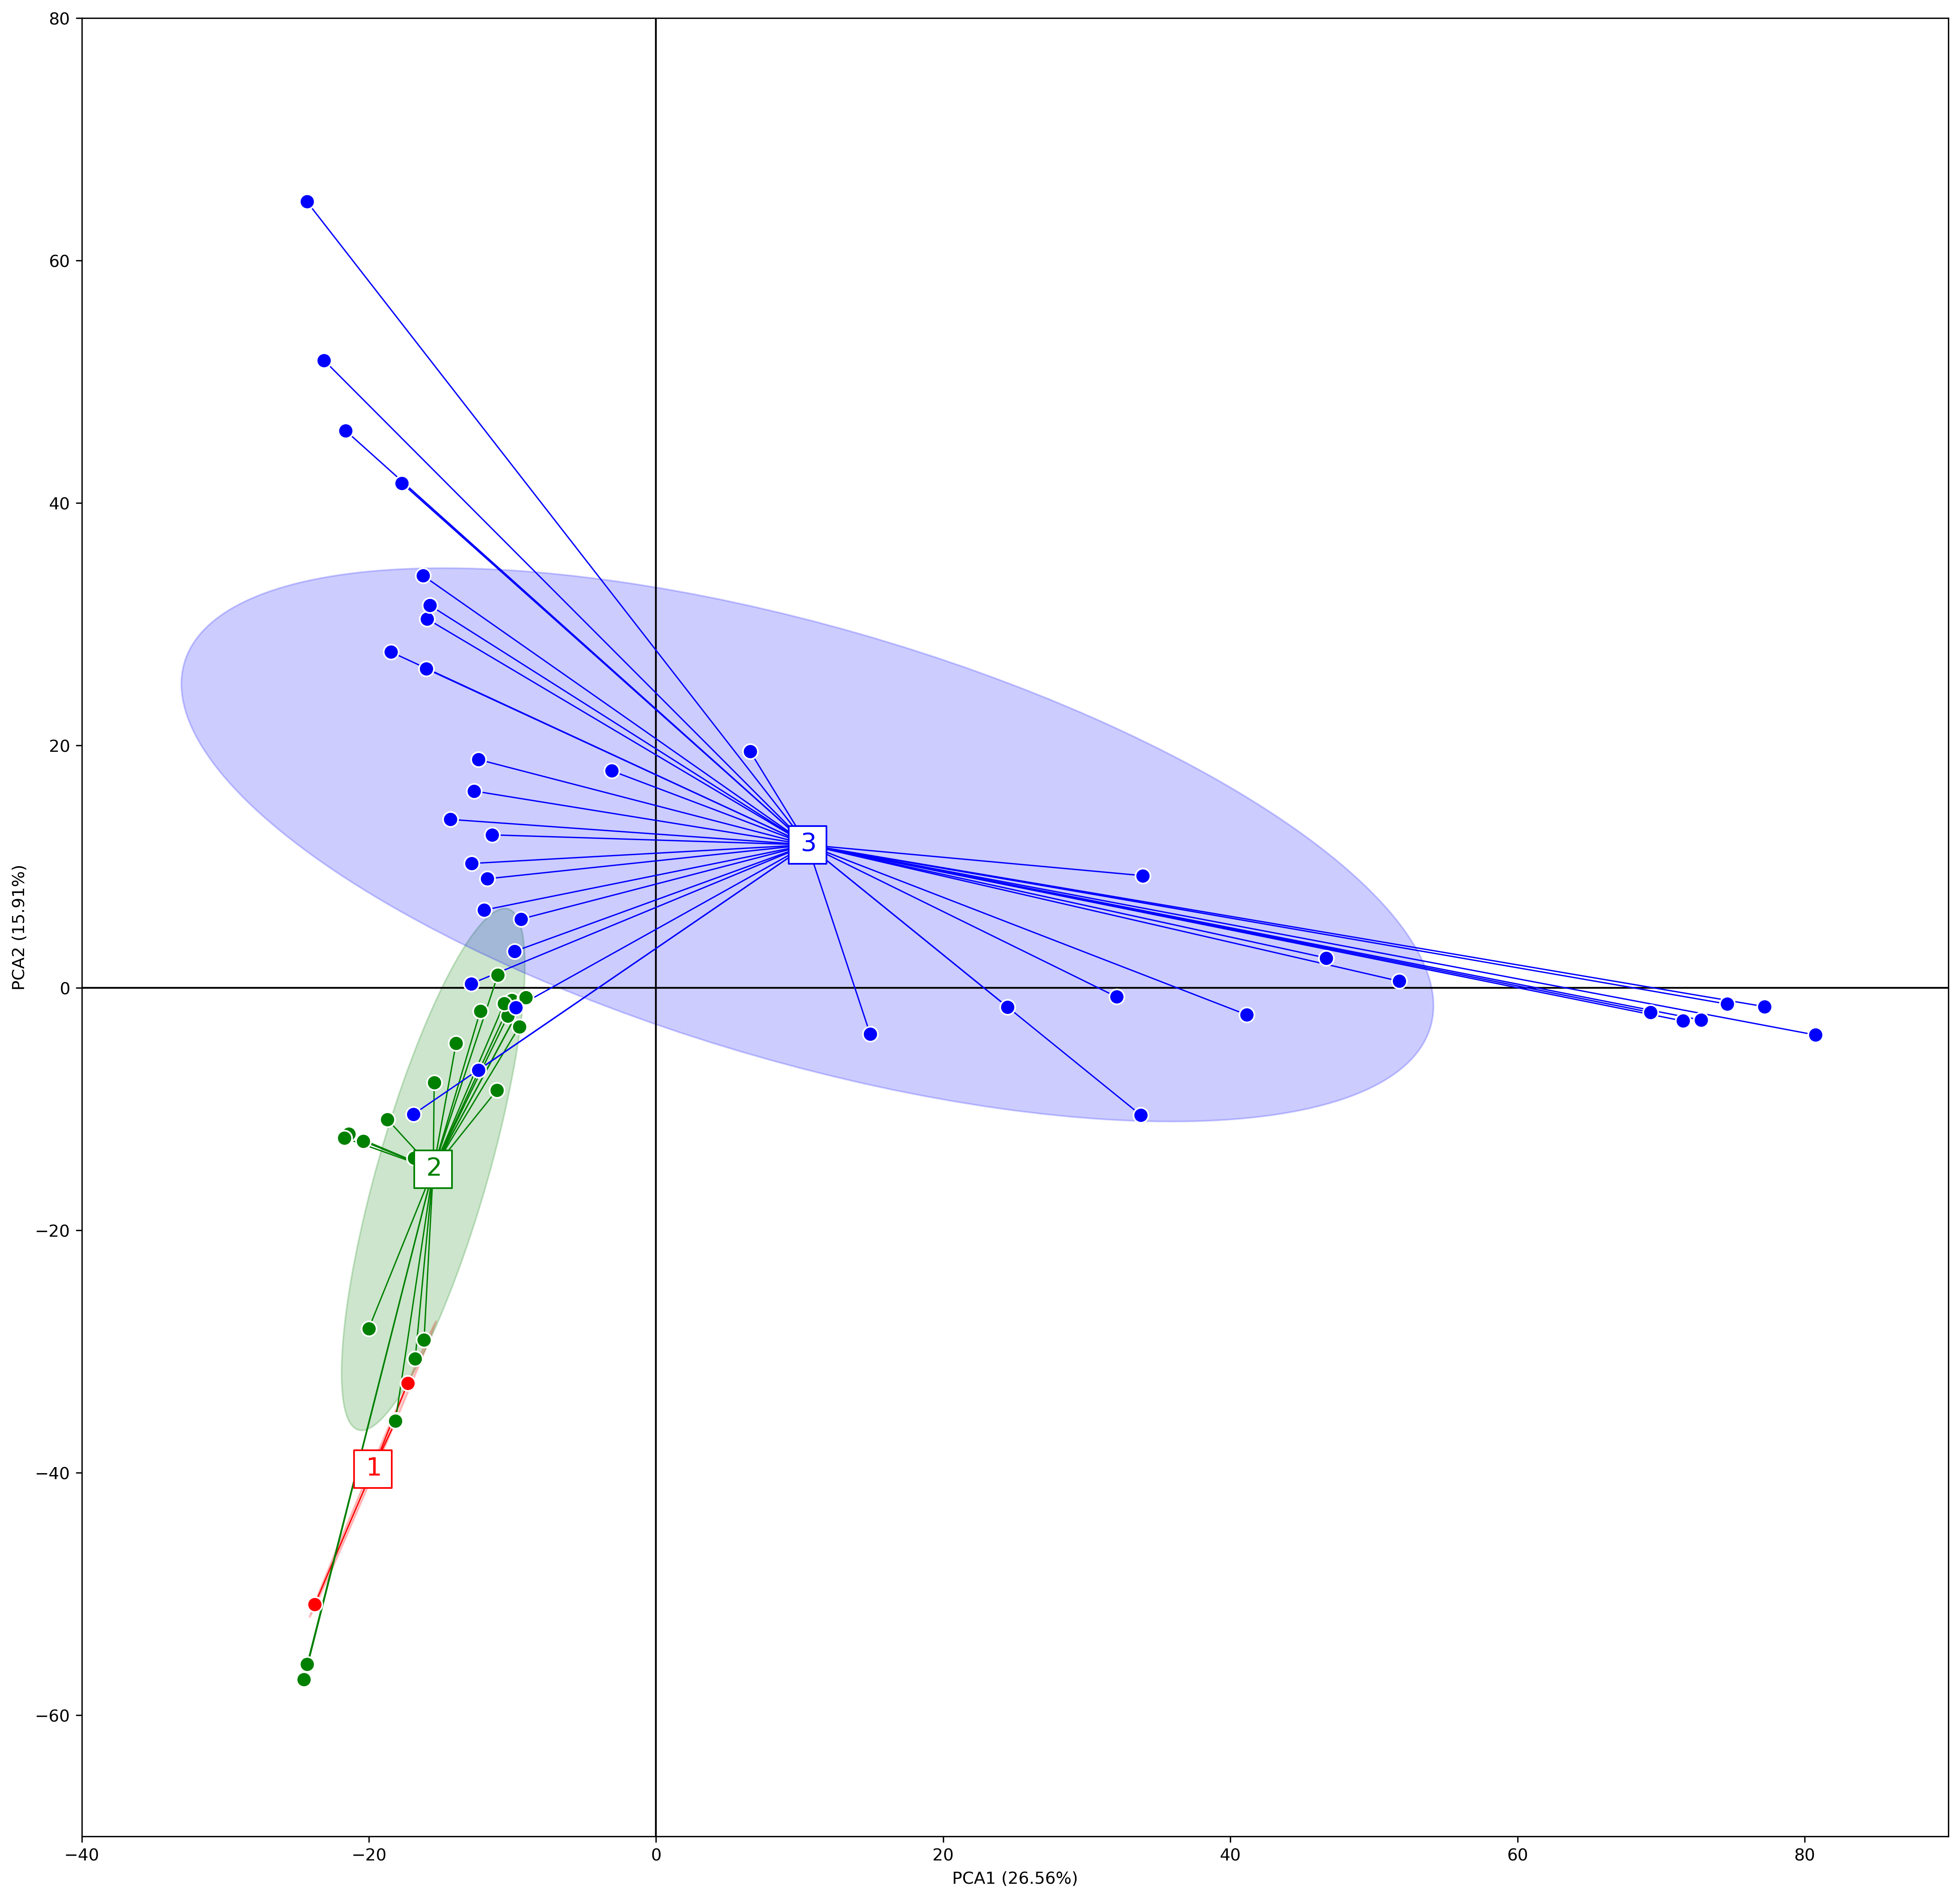

In [123]:
from sklearn.decomposition import NMF, PCA
#model = NMF(n_components=2, init='random', random_state=42)
model = PCA(n_components=2, random_state=42)
W = model.fit_transform(wms.T)
model.explained_variance_ratio_
pca = pd.DataFrame(W, columns=['CS1', 'CS2'])
cluster = enterotype['Cluster'].values

def plot_scatters(ax, x, y, color, marker, label, fontsize=18):
    _ = ax.vlines(x=0, ymin=-70, ymax=80, lw=1, ls='-', color='k', zorder=-0)
    _ = ax.hlines(y=0, xmin=-40, xmax=90, lw=1, ls='-', color='k', zorder=-0)
    _ = ax.scatter(x, y, marker=marker, lw=1, color=color, label=label, s=80, ec='white', zorder=7)
    centerx, centery = x.mean(), y.mean()
    _ = ax.scatter([centerx], [centery], lw=1, color='white', marker='s', s=500, ec=color, zorder=8)
    _ = ax.annotate(label, [centerx-0.5, centery-0.5], fontsize=15, color=color, zorder=9)
    for i in range(len(x)):
        _ = ax.plot([centerx, x[i]], [centery, y[i]], color=color, lw=0.8, zorder=6)
    _ = plot_ellipses(ax, x, y, std=1.25, facecolor=color, edgecolor=color, alpha=0.2)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax = plt.subplot(1,1,1)
plot_scatters(ax, pca.loc[cluster==1, 'CS1'].values, pca.loc[cluster==1, 'CS2'].values, 'r', 'o', '1', fontsize=18)
plot_scatters(ax, pca.loc[cluster==2, 'CS1'].values, pca.loc[cluster==2, 'CS2'].values, 'g', 'o', '2', fontsize=18)
plot_scatters(ax, pca.loc[cluster==3, 'CS1'].values, pca.loc[cluster==3, 'CS2'].values, 'b', 'o', '3', fontsize=18)
_ = plt.xlabel('PCA1 (26.56%)')
_ = plt.ylabel('PCA2 (15.91%)')
_ = plt.xlim([-40, 90])
_ = plt.ylim([-70, 80])
fig.savefig('../Results_0609/6.6. WMS_肠型_pca.pdf', dpi=300)

### PCOA

,C11_13,C11_22,C11_25,C11_26,C11_27,C11_4,C11_5,C12_13,C12_22,C12_25,...,C33_5,C35_22,C35_5,C4_26,C4_27,C5_22,C5_25,C5_27,C5_4,C19_5
C11_13,0.0,0.831253,0.932072,0.947132,0.989599,0.39569,0.401678,0.997192,0.994173,0.974181,...,0.537993,0.43981,0.994759,0.831297,0.996737,0.886586,0.994835,0.995828,0.998189,0.994137


(0.18524322922709457, 0.1603126409703987)

### 分组检验


method name                 ANOSIM
test statistic name              R
sample size                     63
number of groups                 3
test statistic            0.447094
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      63
number of groups                  3
test statistic             6.001292
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

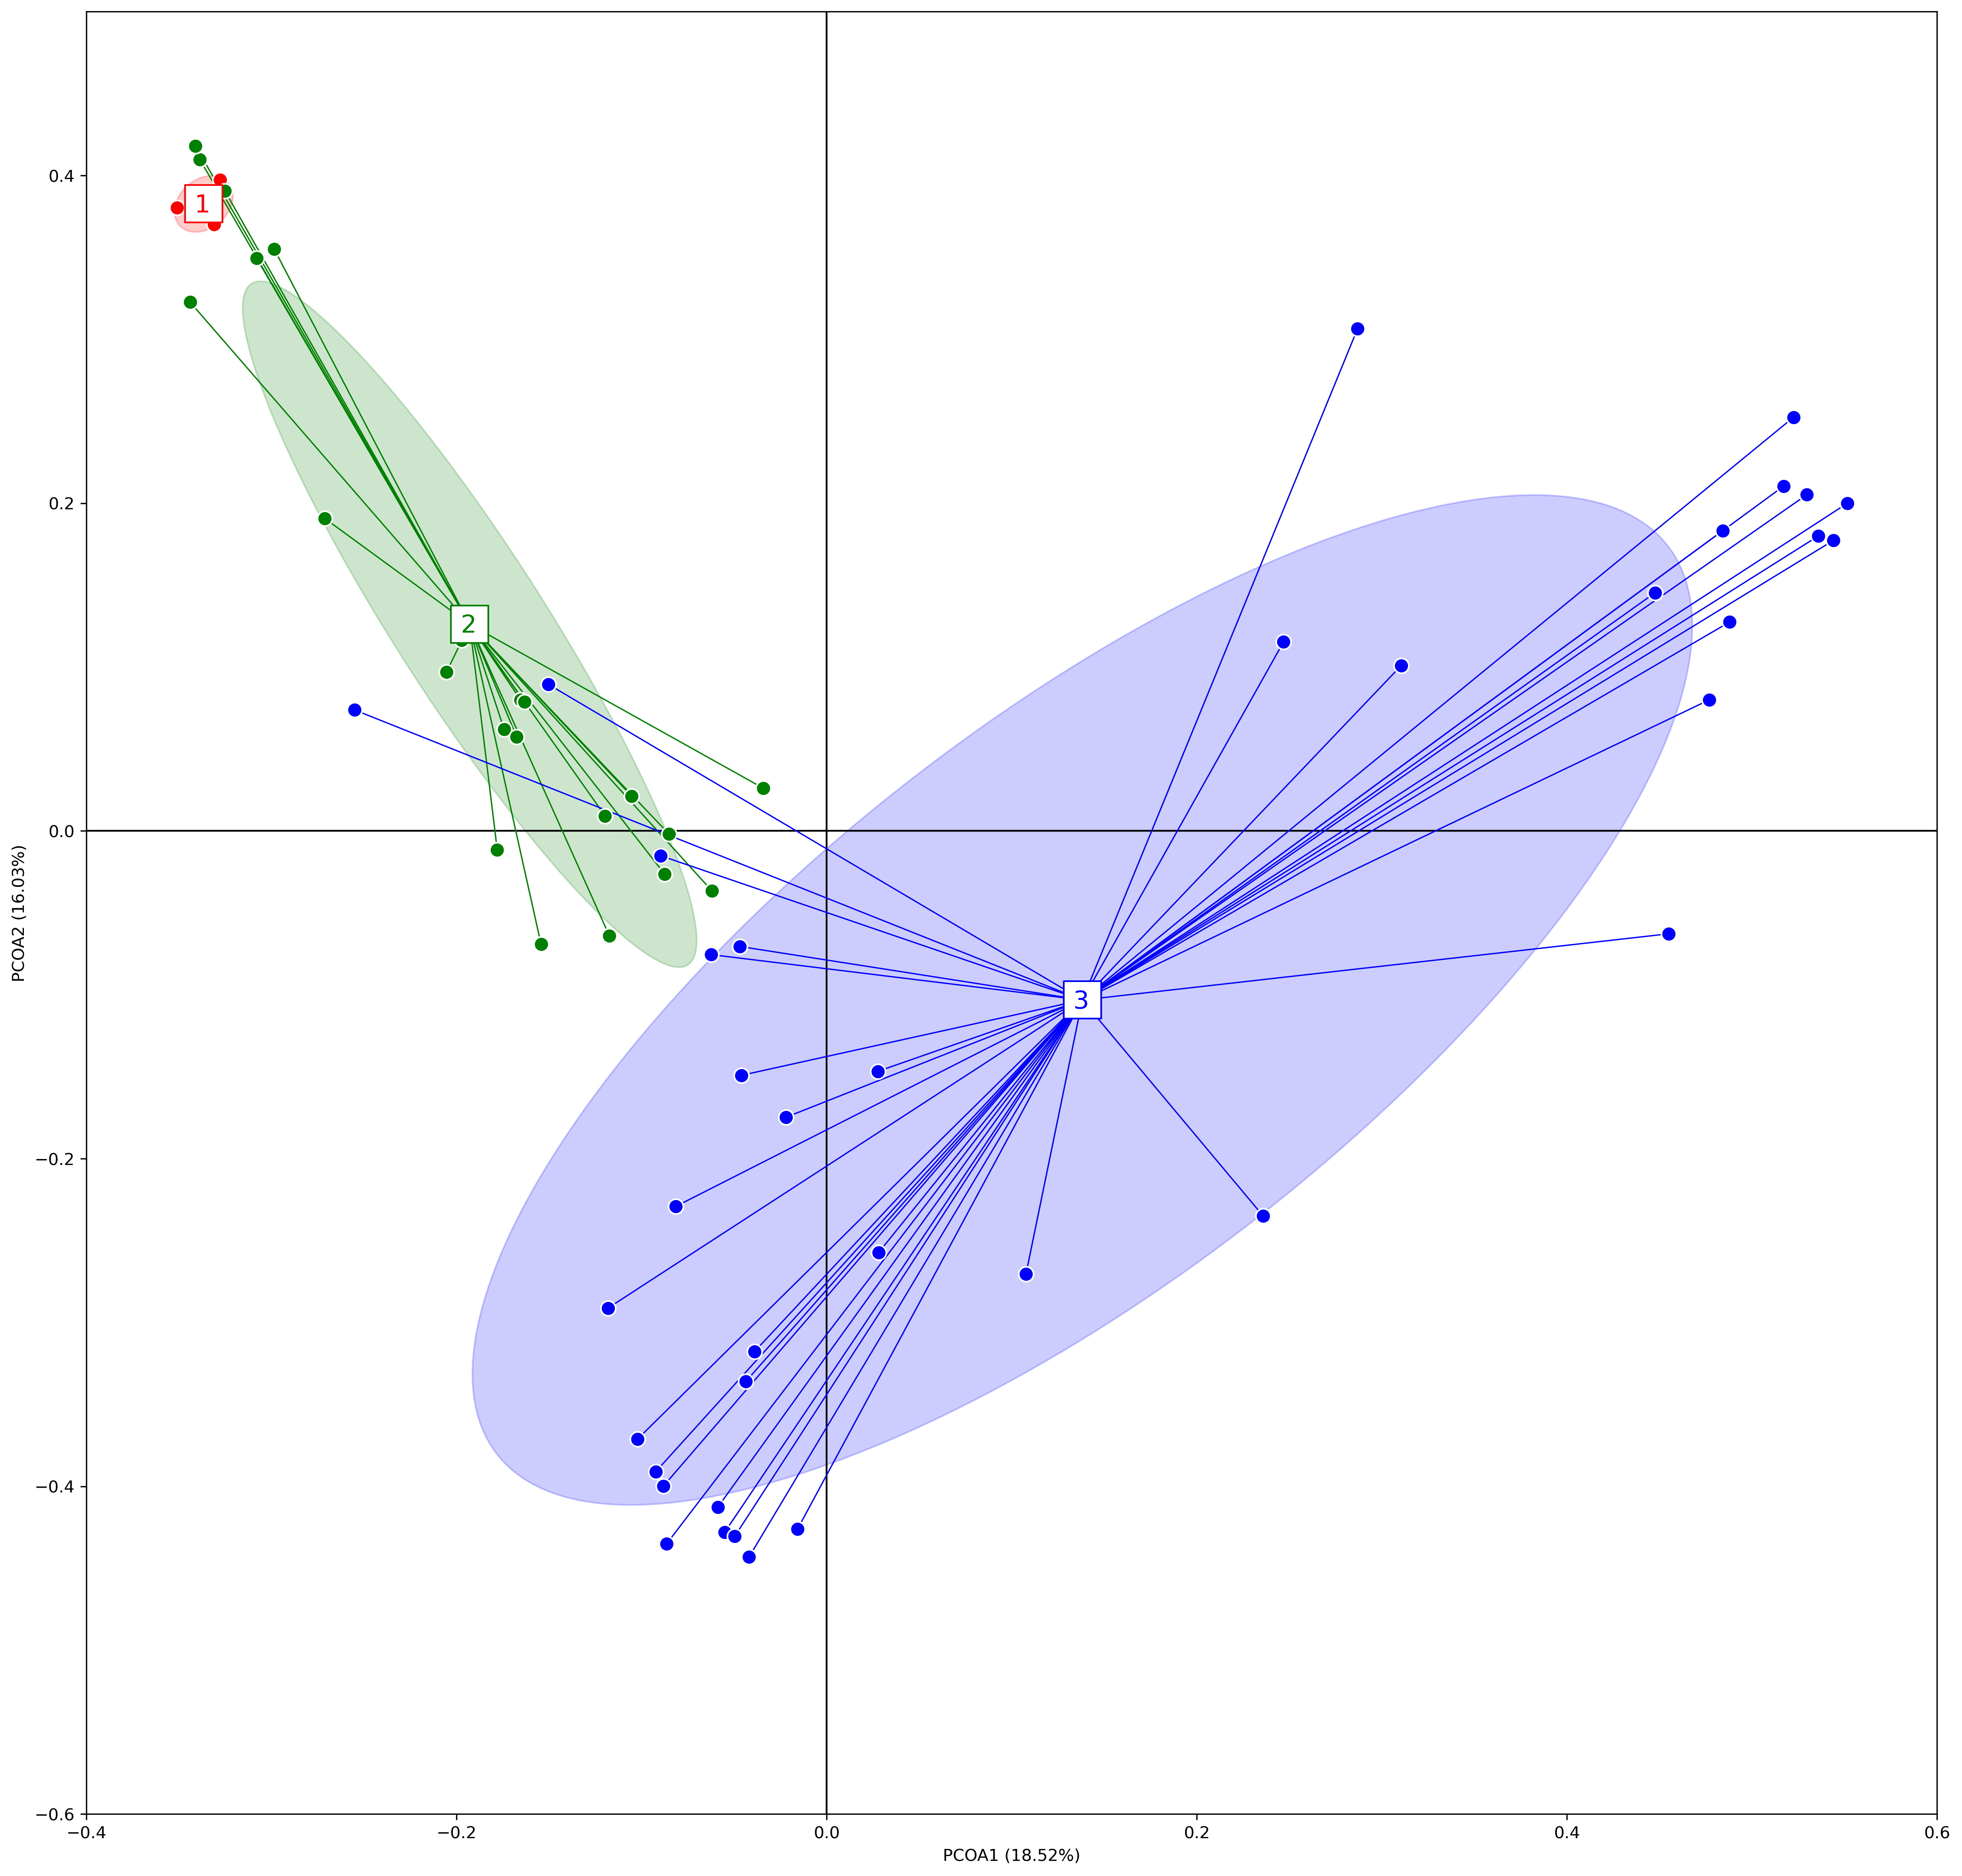

In [129]:
from scipy.spatial.distance import braycurtis, euclidean, correlation, cosine
from skbio import DistanceMatrix
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import anosim, permanova
distance_matrix = pd.DataFrame(np.zeros((wms.shape[1], wms.shape[1])), index=wms.columns, columns=wms.columns)
for i in distance_matrix:
    for j in distance_matrix:
        distance_matrix.loc[i, j] = braycurtis(wms[i], wms[j])
distance_matrix.head(1)

groups = enterotype['Cluster'].values
ordination_result = pcoa(DistanceMatrix(distance_matrix.values, list(distance_matrix.index)))
pc1, pc2 = ordination_result.proportion_explained.loc['PC1'], ordination_result.proportion_explained.loc['PC2']
pc1, pc2
pca = ordination_result.samples

dm = DistanceMatrix(distance_matrix.values, list(distance_matrix.index))
print('### 分组检验')
anosim(dm, grouping=groups)
permanova(dm, grouping=groups)

def plot_scatters(ax, x, y, color, marker, label, fontsize=18):
    _ = ax.vlines(x=0, ymin=-0.6, ymax=0.5, lw=1, ls='-', color='k', zorder=-0)
    _ = ax.hlines(y=0, xmin=-0.4, xmax=0.6, lw=1, ls='-', color='k', zorder=-0)
    _ = ax.scatter(x, y, marker=marker, lw=1, color=color, label=label, s=80, ec='white', zorder=7)
    centerx, centery = x.mean(), y.mean()
    _ = ax.scatter([centerx], [centery], lw=1, color='white', marker='s', s=500, ec=color, zorder=8)
    _ = ax.annotate(label, [centerx-0.005, centery-0.005], fontsize=15, color=color, zorder=9)
    for i in range(len(x)):
        _ = ax.plot([centerx, x[i]], [centery, y[i]], color=color, lw=0.8, zorder=6)
    _ = plot_ellipses(ax, x, y, std=1.25, facecolor=color, edgecolor=color, alpha=0.2)
    
fig = plt.figure(figsize=(20, 20), dpi=300)
ax = plt.subplot(1,1,1)
plot_scatters(ax, pca.loc[cluster==1, 'PC1'].values, pca.loc[cluster==1, 'PC2'].values, 'r', 'o', '1', fontsize=18)
plot_scatters(ax, pca.loc[cluster==2, 'PC1'].values, pca.loc[cluster==2, 'PC2'].values, 'g', 'o', '2', fontsize=18)
plot_scatters(ax, pca.loc[cluster==3, 'PC1'].values, pca.loc[cluster==3, 'PC2'].values, 'b', 'o', '3', fontsize=18)
_ = plt.xlabel('PCOA1 (18.52%)')
_ = plt.ylabel('PCOA2 (16.03%)')
_ = plt.xlim([-0.4, 0.6])
_ = plt.ylim([-0.6, 0.5])
fig.savefig('../Results_0609/6.6. WMS_肠型_pcoa_braycurtis.pdf', dpi=300)